<div id="container" style="position:relative;">
<div style="float:left"><h1> Model 4 : Facebook Prophet</h1></div>
<div style="position:relative; float:right"><img style="height:65px" src ="https://twomagpiesbakery.co.uk/wp-content/uploads/2020/11/logo-no-site.jpg" />
</div>
</div>

**Steps to calculate the Facebook Prophet model for a daily, weekly and monthly revenue forecast.**


**Accuracy Evaluation** 
The models will then be evaluated by calculating the:
- Root Mean Squared Error (RMSE) 
- R<sup>2</sup> 
- Mean Average Error (MAE)
- Mean Average Percentage Error (MAPE) 

The model with the best MAPE scores, as determined in `Model 2 - Linear Regression` to be the most suitable for determining the the accuracy of the model, will be selected as the optimal Facebook Prophet model for the daily, weekly and monthly forecast. 

**N.B** The grid search code cells have been hashed out so that if this notebook is run those cells aren't, this also includes the result cells below indicating the best parameters. This is because otherwise the notebook takes c.6 hours to run. Images of the results from the grid search have been entered in the cells below to show the results. Images of all the plotly graphs have been entered as well in case the notebook is not run. 

---

# Contents 

**[Executive Summary](#Executive-Summary)**

**[1. Daily Revenue Forecast](#1.-Daily-Revenue-Forecast)**

   - [Determining the Best Daily Forecast](#Determining-the-Best-Daily-Forecast)
   - [Visualising the Forecast Components of the Best Daily Model](#Visualising-the-Forecast-Components-of-the-Best-Daily-Model)
    
**[2. Weekly Revenue Forecast](#2.-Weekly-Revenue-Forecast)**

   - [Determining the Best Weekly Forecast](#Determining-the-Best-Weekly-Forecast)
   - [Visualising the Forecast Components of the Best Weekly Model](#Visualising-the-Forecast-Components-of-the-Best-Weekly-Model)
**[3. Monthly Revenue Forecast](#3.-Monthly-Revenue-Forecast)**

   - [Determining the Best Monthly Forecast](#Determining-the-Best-Monthly-Forecast)
   - [Visualising the Forecast Components of the Best Monthly Model](#Visualising-the-Forecast-Components-of-the-Best-Monthly-Model)
   
    
**[Summary](#Summary)**

**[Further Improvements](#Further-Improvements)**

**[Next Steps](#Next-Steps)**
___

# Executive Summary 

- A total of 13 iterations were made for the daily, weekly and monthly forecasts. The best model for each are summarised in the table below with their MAPE scores and additional information about the hyperparameters and exogenous datasets used. 
- The weekly forecast performed particularly well with holidays added and was good at accounting for the change in revenue due to the summer holidays.
- The monthly model was very poor and produced very inaccurate results, worse than the simple baseline moving average. This is most likely due to the severe lack of data points for the Facebook Prophet model to successfully determine the trend. 

|Forecast| Model | MAPE | Comments |
|:--| :- | :- | :--|
|Daily|5| 9.5 %| Added TAVG |
|Weekly|4| 8.5 %| Holidays and tuned hyperparameters| 
|Monthly|2| 28.0 %| Hyperparameters tuned, no holidays|

---

## Importing Libraries

In [1]:
# Main libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import sklearn.metrics  
import itertools
import datetime as dt
import warnings
warnings.filterwarnings('ignore', category=Warning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_plotly, plot_components_plotly
from fbprophet.plot import plot_cross_validation_metric
import plotly.express as px
import plotly.graph_objects as go
import os

from plotly.subplots import make_subplots
from pandas.tseries.offsets import DateOffset

## Importing Custom Functions

In [2]:
import BakeryFunctions as bakery

## To Get Current Directory

In [3]:
working_directory = os.getcwd()
working_directory

'/Users/abimagnall/Documents/BrainStation/Capstone/Data'

## Importing Preprocessed Dataset

In [328]:
# Importing the dataset
total_rev = pd.read_csv(working_directory+'/5_timeseries_data/total_revenue.csv', index_col=0)
# Converting the index to a datetime index 
total_rev.index = pd.to_datetime(total_rev.index)
# To get temperature information 
tavg_rev = total_rev.drop(columns=['Day', 'PRCP', 'CPI_Electricity', 'CPI_Food']).copy()
# To drop redundant cols for the revenue 
total_rev.drop(columns=['Day', 'TAVG', 'PRCP', 'CPI_Electricity', 'CPI_Food'],inplace=True)
# To validate it imported correctly 
display(tavg_rev.head())
display(total_rev.head())

Total_Revenue  TAVG
2020-09-01        9780.76  24.0
2020-09-02       10037.55  27.0
2020-09-03        9419.30  31.0
2020-09-04       10606.15  27.0
2020-09-05       12922.00  23.0

Total_Revenue
2020-09-01        9780.76
2020-09-02       10037.55
2020-09-03        9419.30
2020-09-04       10606.15
2020-09-05       12922.00

In [5]:
# Importing the holidays dataset
holidays = pd.read_csv(working_directory+'/5_timeseries_data/school_holidays_fb.csv', index_col=1)
# Converting the index to a datetime index 
holidays.index = pd.to_datetime(holidays.index)
holidays.head()

School Holiday
Date                      
2020-10-24  School Holiday
2020-10-25  School Holiday
2020-10-26  School Holiday
2020-10-27  School Holiday
2020-10-28  School Holiday

In [ ]:
# Importing the weather dataset
holidays = pd.read_csv(working_directory+'/5_timeseries_data/school_holidays_fb.csv', index_col=1)
# Converting the index to a datetime index 
holidays.index = pd.to_datetime(holidays.index)
holidays.head()

---

# 1. Daily Revenue Forecast
First, Prophet expects the data to be in a specific format: a dataframe with two columns, `ds` and `y` for the dates and observations, therefore the column will be renamed and the data is split into train and test sets as determined by the business, which is to predict the next 7 days of revenue.

*Therefore, anything before the date 24-02-2022 is the train dataset and on or post is test dataset.*


In [6]:
# Copy of the data is taken for audit trail purposes
prophet_full_daily = total_rev.reset_index().copy()
# Columns are renamed to ds and y 
prophet_full_daily.rename(columns={'index': 'ds', 'Total_Revenue': 'y'}, inplace=True)
# To validate it is in the correct format
prophet_full_daily.head()

ds         y
0 2020-09-01   9780.76
1 2020-09-02  10037.55
2 2020-09-03   9419.30
3 2020-09-04  10606.15
4 2020-09-05  12922.00

In [144]:
# Train dataset created 
prophet_train_daily = prophet_full_daily.loc[prophet_full_daily.ds <= '2022-09-23']
# To validate it is in the correct format
prophet_train_daily.tail()

ds          y
748 2022-09-19  12724.135
749 2022-09-20   9615.100
750 2022-09-21  10111.170
751 2022-09-22   9236.430
752 2022-09-23  11410.190

In [146]:
# Test dataset cresated 
prophet_test_daily = prophet_full_daily.loc[prophet_full_daily.ds > '2022-09-23']
# To validate it is in the correct format
prophet_test_daily.tail()

ds         y
755 2022-09-26   9932.92
756 2022-09-27   9718.01
757 2022-09-28   8069.91
758 2022-09-29   7877.02
759 2022-09-30  11183.32

---

# Model 1 - Baseline Model
For the baseline daily model, no hyperparameter tuning will occur, the train data will be entered with just the `yearly_seasonality` and `weekly_seasonality` set to True, as the data is known to show both yearly and weekly seasonality. 

In [303]:
# First an empty results dataframe is created to track the accuracy of the models run
daily_model_scores = pd.DataFrame()

In [363]:
# To fit the model 
model_daily_baseline = Prophet(yearly_seasonality=True, weekly_seasonality=True)
model_daily_baseline.fit(prophet_train_daily)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


To make the predictions using the fitted model, a dataframe is created using the `make_future_dataframe`. This works by creating a dataframe with dates in a column names `ds` at the length of the inputted `periods` and `freq`. For daily revenue forecast, this is 7 days. 

In [364]:
# A dataframe is created using the make_future_dataframe
future_daily = model_daily_baseline.make_future_dataframe(periods=7, freq='D', include_history=False)
future_daily.head()

ds
0 2022-09-24
1 2022-09-25
2 2022-09-26
3 2022-09-27
4 2022-09-28

The `.predict` method is then called on the above created future dataframe, which populates it with the `yhat` (predicted) values, along with the upper and lower bounds of the prediction. 

In [365]:
# Predict method to forecast using the fitted model 
forecast_daily_baseline = model_daily_baseline.predict(future_daily)
forecast_daily_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds          yhat   yhat_lower    yhat_upper
2 2022-09-26   9794.191206  7715.524243  11946.351882
3 2022-09-27   8896.362875  6823.592369  11251.762442
4 2022-09-28   8921.421446  6716.819521  11053.784536
5 2022-09-29   8943.450674  6832.281355  11095.321682
6 2022-09-30  10868.856246  8591.433471  12894.457225

In [366]:
# To plot the results of the actual vs forecasted revenue
fig = go.Figure()

# Add actual vs forecasted revenue 
fig.add_trace(go.Scatter(x=prophet_full_daily['ds'], y=prophet_full_daily['y'], mode='lines', name='Actual Revenue',
              line={'color' : bakery.light_magpie}))
fig.add_trace(go.Scatter(x=forecast_daily_baseline['ds'], y=forecast_daily_baseline['yhat'], mode='lines',
                         name='Forecasted Revenue',
                         line={'dash': 'dash', 'color': bakery.red_magpie}))

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    yaxis_title='Revenue (£)',
    xaxis_title='Date',
    legend_title='',
    title='Model 1 - Baseline Daily Forecasted')
fig.show()

*Image of the above plotly graph for model 1:*

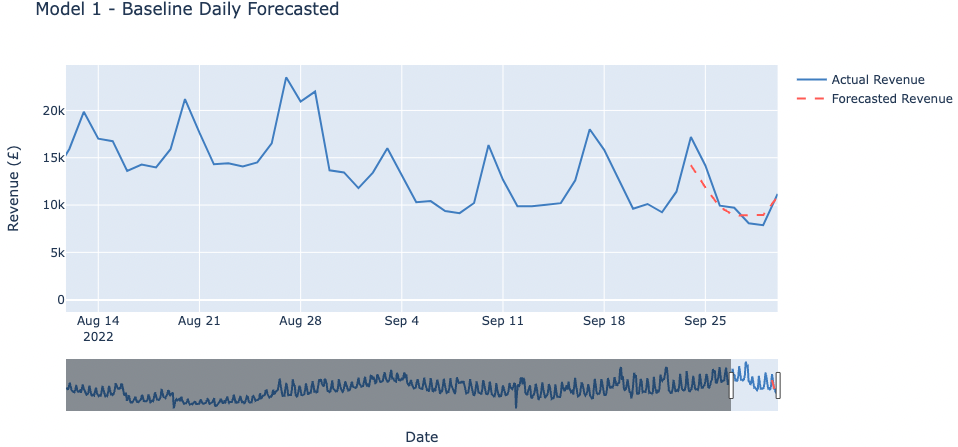

In [15]:
# To assess the accuracy of the baseline model 
bakery.full_accuracy_report(prophet_test_daily['y'], forecast_daily_baseline['yhat'], 'daily forecast')

The R2 for the daily forecast is: 0.756

The RMSE for the daily forecast is: 1554.39

The MAE between the actual and daily forecast revenue is 1212.78

The MAPE between the actual and daily forecast revenue is 10.1%


### Evaluation of Model 1 Daily Baseline
From the above results and graph it can be seen that the daily forecast is fitted relatively well to the actual revenue, with a MAPE score of 10.1%. However, this is not better than previous models built. Therefore, a grid search will be conducted in an attempt to improve the models accuracy by finding the optimal tuned hyperparameters. 

In [304]:
# To add the scores to the results table 
daily_model_scores = bakery.add_results(daily_model_scores, 1,
                                        0.756, 1554.39, 'N/A', '10.1%', 'Baseline model')

Model     R2     RMSE  AIC MAPE (%)        Comments
0      1  0.756  1554.39  N/A    10.1%  Baseline model

# Hyperparameter Tuning
Next, to find the optimal hyperparameters required for the model cross validation is used. 

For this the parameters being tuned are: 
- `change_prior_scale` - this determines the flexibility of the trend, and in particular how much the trend changes at the trend changepoints. As described in this documentation, if it is too small, the trend will be underfit and variance that should have been modeled with trend changes will instead end up being handled with the noise term. If it is too large, the trend will overfit and in the most extreme case you can end up with the trend capturing yearly seasonality.,
- `seasonality_prior_scale` - This parameter controls the flexibility of the seasonality. A large value allows the seasonality to fit large fluctuations, a small value shrinks the magnitude of the seasonality.

The parameters that produce the lowest RMSE then will be selected as the optimal parameters and run in the model. RMSE was selected for multiple reasons: 

- Firstly, optimization fo RMSE seeks to be correct on average, as opposed to MAE which will target the median. This means MAE deals with outliers better. However, in the data it is known that there are multiple seasonalities (weekly, monthly and annually). Therefore, the MAE may mistake a bank holiday weekend as an outlier and by optimizing the MAE the forecast will be under predicted.
- The RMSE does not treat all errors the same. It gives more importance to the most significance errors. Therefore, by lowering the RMSE this should decrease the larger errors in the forecast, making it more relible. 
- Finally, it was recommended in the documentation to use RMSE. 

**How the Cross Validation Works**

Facebook Prophet's cross validation works by training the model on the initial first 600 days, and forecast the next 7 days (the horizon paramter). It then adds 7 days worth of data (the period parameter) and forecasts the next 7 days, and repeats this until there is no more train data remaining. This means that the models will be fitted 10 times with each different `changepoint_prior_scale` and `seasonality_prior_scale` as provided in the parameter grid. 

The RMSE scores are then collected in a list and the hyperparameters used to make a model with the lowest RMSE score can be determined. 

**N.B** *The below cell has be commented out so that it does not run due to the computational power and time required. Screenshots of the results can be found below.*

In [313]:
# # The parameter grid is set up with the values being tested for each parameter 
# param_grid = {  
#     'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
#     'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]}

# # The zip is used to generate all combinations of parameters
# all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

# # To store the RMSEs for each params here
# daily_rmses = [] 

# # Cross validation is used to evaluate all parameters
# for params in all_params:
#     # Fit model with given params
#     m = Prophet(**params, yearly_seasonality=True, weekly_seasonality=True).fit(prophet_train_daily)
#     df_cv_daily = cross_validation(m,initial = '600 days', period = '7 days', horizon = '7 days', parallel='processes')
#     df_p_daily = performance_metrics(df_cv_daily, rolling_window=1)
#     daily_rmses.append(df_p_daily['rmse'].values[0])

In [286]:
# # Best hyperparameters
# daily_best_params = all_params[np.argmin(daily_rmses)]
# print(f'The optimum hyperparameters are: {daily_best_params}')
# print('')
# daily_best_rmse = np.argmin(daily_rmses)
# print(f'The lowest RMSE is: {round(daily_rmses[daily_best_rmse],2)}')

The optimum hyperparameters are: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0}

The lowest RMSE is: 2513.51


Results from `Best hyperparameters` cell block are: 
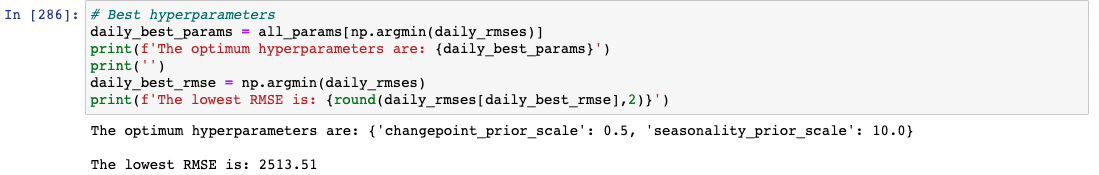

# Model 2 - Fitting the Model with the Tuned Hyperparameters 
Now the best hyperparameters have been determined, the model can be fitted on the train data.

In [360]:
model_daily = Prophet(yearly_seasonality=True, weekly_seasonality=True,
                      changepoint_prior_scale=0.5,seasonality_prior_scale=10)
model_daily.fit(prophet_train_daily)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The `predict` method is called again on the made future_daily dataframe to predict the new fitted model forecast.

In [361]:
# To predict the new forecast using the model with tuned hyperparameters
forecast_daily = model_daily.predict(future_daily)
forecast_daily[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds          yhat   yhat_lower    yhat_upper
2 2022-09-26  10216.667610  8081.214892  12401.842063
3 2022-09-27   9343.429818  6975.971104  11536.333679
4 2022-09-28   9397.751120  7198.411920  11649.118023
5 2022-09-29   9448.814425  7215.745538  11526.490675
6 2022-09-30  11402.787265  9215.199947  13327.993245

In [362]:
# To plot the results from the fitted model 
fig = go.Figure()

# Add actual vs forecasted revenue 
fig.add_trace(go.Scatter(x=prophet_full_daily['ds'], y=prophet_full_daily['y'], mode='lines', name='Actual Revenue',
              line={'color' : bakery.light_magpie}))
fig.add_trace(go.Scatter(x=forecast_daily['ds'], y=forecast_daily['yhat'], mode='lines', name='Forecasted Revenue',
                         line={'dash': 'dash', 'color': bakery.red_magpie}))

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    yaxis_title='Revenue (£)',
    xaxis_title='Date',
    legend_title='',
    title='Model 2 - Tuned Hyperparameters Daily Forecasted')
fig.show()

*Image of the above plotly graph for model 2:*

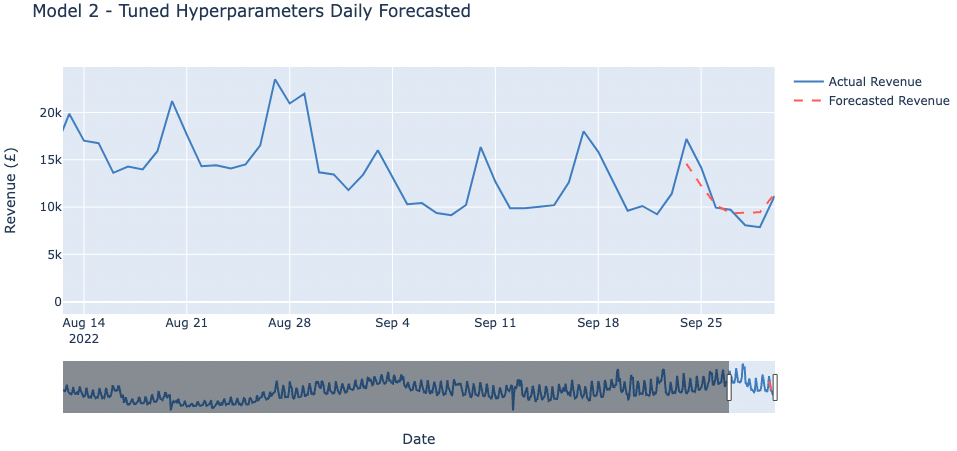

## Evaluation of the Model

In [293]:
bakery.full_accuracy_report(prophet_test_daily['y'], forecast_daily['yhat'], 'daily forecast')

The R2 for the daily forecast is: 0.783

The RMSE for the daily forecast is: 1466.62

The MAE between the actual and daily forecast revenue is 1188.15

The MAPE between the actual and daily forecast revenue is 10.6%


## Evaluation Observations



In [315]:
# To add the scores to the results table 
daily_model_scores = bakery.add_results(daily_model_scores, 2,
                                        0.783, 1466.62, 'N/A', '10.6%', 'After tuning hyperparmeters')

Model     R2     RMSE  AIC MAPE (%)                     Comments
0      1  0.756  1554.39  N/A    10.1%               Baseline model
1      2  0.783  1466.62  N/A    10.6%  After tuning hyperparmeters

# Daily Revenue Forecast with Holidays
The above process will now be repeated except with holiday days added (e.g. a column indicating whether it is a school or bank holiday or not). This is expected to increase the accuracy of the model as it allows it provides additional information about the day being forecasted, as it is known from the EDA that school and bank holidays on tend to have more revenue generated than non-holiday days. This can be done with Facebook Prophet by entering the special days as a dataframe into the parameter `holiday` when fitting the model. 

In [111]:
# Holiday dataframe is set up correctly
holidays_train = holidays.reset_index().copy()
holidays_train.rename(columns={'Date': 'ds', 'School Holiday': 'holiday'}, inplace=True)
holidays_train.head()

ds         holiday
0 2020-10-24  School Holiday
1 2020-10-25  School Holiday
2 2020-10-26  School Holiday
3 2020-10-27  School Holiday
4 2020-10-28  School Holiday

# Model 3 - Baseline Daily Forecast with Holidays
The baseline model with holiday dates added is run with no hyperparameter tuning. 

In [357]:
model_hols = Prophet(yearly_seasonality=True, weekly_seasonality=True, holidays=holidays_train)
model_hols.fit(prophet_train_daily)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [358]:
# The forecast is made using the predict method 
baseline_forecast_hols = model_hols.predict(future_daily)
baseline_forecast_hols[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds          yhat   yhat_lower    yhat_upper
2 2022-09-26   9346.878711  7447.936511  11168.292095
3 2022-09-27   8804.539815  7060.692958  10581.269460
4 2022-09-28   8868.644576  6920.893034  10858.136885
5 2022-09-29   8855.119753  7123.379629  10755.215172
6 2022-09-30  10795.536480  8825.478425  12731.665490

In [359]:
# To plot the actual revenue vs the forecasted revenue 
fig = go.Figure()
# Add actual vs forecasted revenue
fig.add_trace(go.Scatter(x=prophet_full_daily['ds'], y=prophet_full_daily['y'], mode='lines', name='Actual Revenue',
              line={'color' : bakery.light_magpie}))
fig.add_trace(go.Scatter(x=baseline_forecast_hols['ds'], y=baseline_forecast_hols['yhat'], mode='lines', 
                         name='Forecasted Revenue',
                         line={'dash': 'dash', 'color': bakery.red_magpie}))

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    yaxis_title='Revenue (£)', 
    xaxis_title='Date',
    legend_title='',
    title='Model 3 - Daily Forecasted Revenue with Special Days Added')
fig.show()

*Image of the above plotly graph for model 3:*
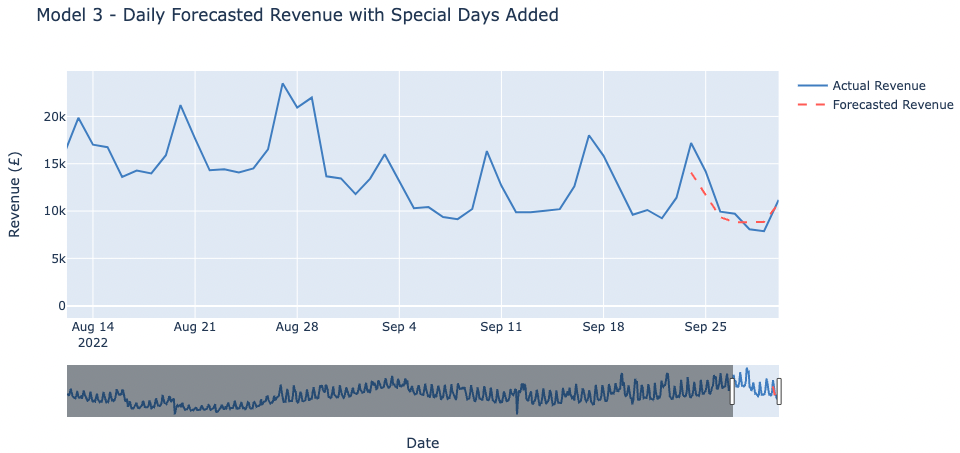

In [49]:
# To evaluate the accuracy of model 3
bakery.full_accuracy_report(prophet_test_daily['y'], baseline_forecast_hols['yhat'], 'daily forecast')

The R2 for the daily forecast is: 0.726

The RMSE for the daily forecast is: 1649.4

The MAE between the actual and daily forecast revenue is 1330.06

The MAPE between the actual and daily forecast revenue is 11.0%


## Model 3 Accuracy Evaluation 
By adding the holiday dates this actually decreased the accuracy of the model slightly. This could be improved by tuning the hyperparameters, which will be explored in Model 4. 

In [317]:
# To add the scores to the results table 
daily_model_scores = bakery.add_results(daily_model_scores, 3,
                                        0.726, 1649.4, 'N/A', '11.0%', 'Adding Holiday Dates')

Model     R2     RMSE  AIC MAPE (%)                     Comments
0      1  0.756  1554.39  N/A    10.1%               Baseline model
1      2  0.783  1466.62  N/A    10.6%  After tuning hyperparmeters
2      3  0.726  1649.40  N/A    11.0%         Adding Holiday Dates

# Tuning Hyperparameters with Speical Dates

The grid search and cross validation method is repeated except with the holiday dataframe added. An additional hyperparameter `holidays_prior_scale` will also be tuned in this search. This hyperparameter controls flexibility to fit holiday effects and therefore how much of an effect the the holiday dates have on the predicted revenue. 

**N.B** *The below grid search cell and best hyperparameter determination have been commented out due to the length of time required to run the cells. An image of the results can be found below.*

In [318]:
# # Gird search and cross validation is performed with holidays added 
# param_grid = {  
#     'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
#     'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
#     'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0]
# }

# # Generate all combinations of parameters
# holiday_all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# holiday_daily_rmses = []  # Store the RMSEs for each params here

# # Use cross validation to evaluate all parameters
# for params in holiday_all_params:
#     # Fit model with given params
#     m = Prophet(**params,holidays=holidays_train,
#                 yearly_seasonality=True, weekly_seasonality=True).fit(prophet_train_daily) 
#     df_cv = cross_validation(m, initial = '600 days', period = '7 days',horizon='7 days', parallel='processes')
#     df_p = performance_metrics(df_cv, rolling_window=1)
#     holiday_daily_rmses.append(df_p['rmse'].values[0])

In [295]:
# # Best hyperparameters",
# daily_best_params = holiday_all_params[np.argmin(holiday_daily_rmses)]
# print(daily_best_params)
# hol_daily_best_rmse = np.argmin(holiday_daily_rmses)
# print(f'The lowest rmse is: {round(holiday_daily_rmses[hol_daily_best_rmse],2)}')

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0}
The lowest rmse is: 2023.67


*Results from the grid search for daily revenue with holiday dates added:*

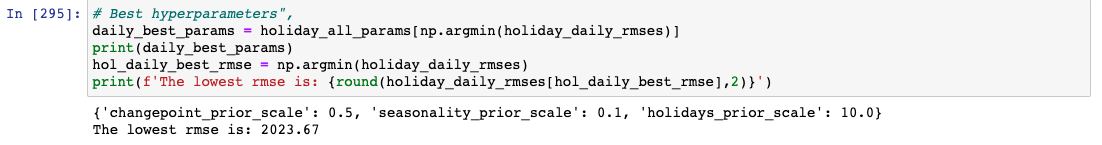

# Model 4 - Re-run with Tuned Hyperparameters

In [305]:
# To fit the model with the tuned hyperparameters
model_daily_hols = Prophet(yearly_seasonality=True, weekly_seasonality=True, holidays=holidays_train,
                        changepoint_prior_scale=0.5, seasonality_prior_scale= 0.1, holidays_prior_scale= 10)
model_daily_hols.fit(prophet_train_daily)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [306]:
# Predicting the forecast with the newly fitted model on the future_daily dataframe
forecast_daily_holiday = model_daily_hols.predict(future_daily)
forecast_daily_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds          yhat   yhat_lower    yhat_upper
2 2022-09-26  10092.961816  8373.375578  11804.683724
3 2022-09-27   9590.076742  7604.794223  11301.219967
4 2022-09-28   9694.701361  7943.300139  11590.620213
5 2022-09-29   9720.739982  7748.782317  11530.776547
6 2022-09-30  11697.186706  9869.889155  13398.472574

In [308]:
# To plot the results
fig = go.Figure()

# Add actual vs forecasted revenue 
fig.add_trace(go.Scatter(x=prophet_full_daily['ds'], y=prophet_full_daily['y'], mode='lines', name='Actual Revenue',
                        line={'color': bakery.light_magpie}))
fig.add_trace(go.Scatter(x=forecast_daily_holiday['ds'], y=forecast_daily_holiday['yhat'], mode='lines',
                         name='Forecasted Revenue', line={'dash': 'dash', 'color': bakery.red_magpie}))

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    yaxis_title='Revenue (£)', 
    xaxis_title='Date',
    legend_title='',
    title='Model 4 - Daily Forecast with Special Days and Tuned Hyperparameters')

fig.show()

*Image of the above plotly graph for model 4:*
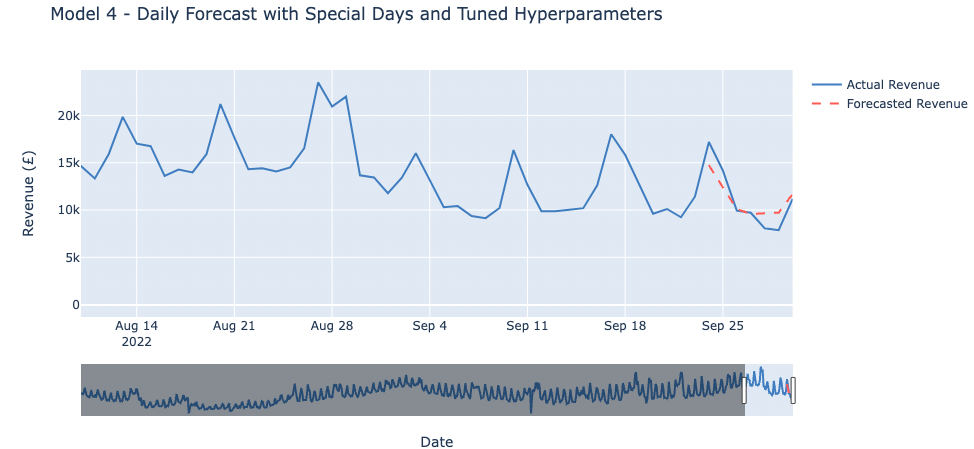

In [310]:
bakery.full_accuracy_report(prophet_test_daily['y'], forecast_daily_holiday['yhat'], 'daily forecast')

The R2 for the daily forecast is: 0.773

The RMSE for the daily forecast is: 1499.07

The MAE between the actual and daily forecast revenue is 1222.1

The MAPE between the actual and daily forecast revenue is 11.2%


## Model 4 Accuracy Evaluation 
This iteration of the model also decreased the accruacy scores compared the baseline with holidays added and the baseline model. 

One reason could be due to overfitting. The grid search works on a train and validation dataset to ensure no leakage of the test data gets into the hyperparameter tuning. However, because of this the model may have overfitted to the train dataset. 

One final method to improve the accuracy of the model is by adding `TAVG` as a regressor. 

In [319]:
# To add the scores to the results table 
daily_model_scores = bakery.add_results(daily_model_scores, 4,
                                        0.773, 1499.07, 'N/A', '11.2%', 'Holidays and tuned hyperparameters')

Model     R2     RMSE  AIC MAPE (%)                            Comments
0      1  0.756  1554.39  N/A    10.1%                      Baseline model
1      2  0.783  1466.62  N/A    10.6%         After tuning hyperparmeters
2      3  0.726  1649.40  N/A    11.0%                Adding Holiday Dates
3      4  0.773  1499.07  N/A    11.2%  Holidays and tuned hyperparameters

# Model 5 - Adding `TAVG` as a Regressor 
With Facebook Prophet it is possible to add additional exogenous data that aren't holiday dates. For the daily forecast, `TAVG` will be added. For this iteration it will have the same hyperparameters as the baseline model 1, which so far is the most accurate model. 

In [330]:
# To set up the dataset with the temperature added for the model with the regressor 
# Copy of the data is taken for audit trail purposes
temp_full_daily = tavg_rev.reset_index().copy()
# Columns are renamed to ds and y 
temp_full_daily.rename(columns={'index': 'ds', 'Total_Revenue': 'y'}, inplace=True)
# To validate it is in the correct format
temp_full_daily.head()

ds         y  TAVG
0 2020-09-01   9780.76  24.0
1 2020-09-02  10037.55  27.0
2 2020-09-03   9419.30  31.0
3 2020-09-04  10606.15  27.0
4 2020-09-05  12922.00  23.0

In [331]:
# Train dataset created for revenue and temp  
temp_train_daily = temp_full_daily.loc[temp_full_daily.ds <= '2022-09-23']
# To validate it is in the correct format
temp_train_daily.tail()

ds          y  TAVG
748 2022-09-19  12724.135  21.0
749 2022-09-20   9615.100  23.0
750 2022-09-21  10111.170  25.0
751 2022-09-22   9236.430  28.0
752 2022-09-23  11410.190  25.0

In [332]:
# Test dataset created for revenue and temp  
temp_test_daily = temp_full_daily.loc[temp_full_daily.ds <= '2022-09-23']
# To validate it is in the correct format
temp_test_daily.tail()

ds          y  TAVG
748 2022-09-19  12724.135  21.0
749 2022-09-20   9615.100  23.0
750 2022-09-21  10111.170  25.0
751 2022-09-22   9236.430  28.0
752 2022-09-23  11410.190  25.0

In [348]:
# To fit the model 
model_daily_reg = Prophet(yearly_seasonality=True, weekly_seasonality=True)
model_daily_reg.add_regressor('TAVG')
model_daily_reg.fit(temp_train_daily)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [349]:
# To add the TAVG data to the future dataframe that will have predictions added to 
future_temp = future_daily.copy()
future_temp['TAVG'] = temp_test_daily['TAVG']

In [350]:
# Predicting the forecast with the newly fitted model on the future_daily dataframe
forecast_daily_temp = model_daily_reg.predict(future_temp)
forecast_daily_temp[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds          yhat   yhat_lower    yhat_upper
2 2022-09-26   9934.114196  7795.668211  11993.906750
3 2022-09-27   8892.650091  6800.930526  11110.456835
4 2022-09-28   8802.726786  6666.359261  11072.526042
5 2022-09-29   8864.692728  6720.910716  10926.244147
6 2022-09-30  10903.460874  8678.963915  13029.655929

In [355]:
# To plot the results of the actual vs forecasted revenue with TAVG added in the model 
fig = go.Figure()

# Add actual vs forecasted revenue 
fig.add_trace(go.Scatter(x=prophet_full_daily['ds'], y=prophet_full_daily['y'], mode='lines', name='Actual Revenue',
              line={'color' : bakery.light_magpie}))
fig.add_trace(go.Scatter(x=forecast_daily_temp['ds'], y=forecast_daily_temp['yhat'], mode='lines',
                         name='Forecasted Revenue',
                         line={'dash': 'dash', 'color': bakery.red_magpie}))

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    yaxis_title='Revenue (£)',
    xaxis_title='Date',
    legend_title='',
    title='Model 5 - Daily Forecast with TAVG')
fig.show()

*Image of the above plotly graph for model 5:*
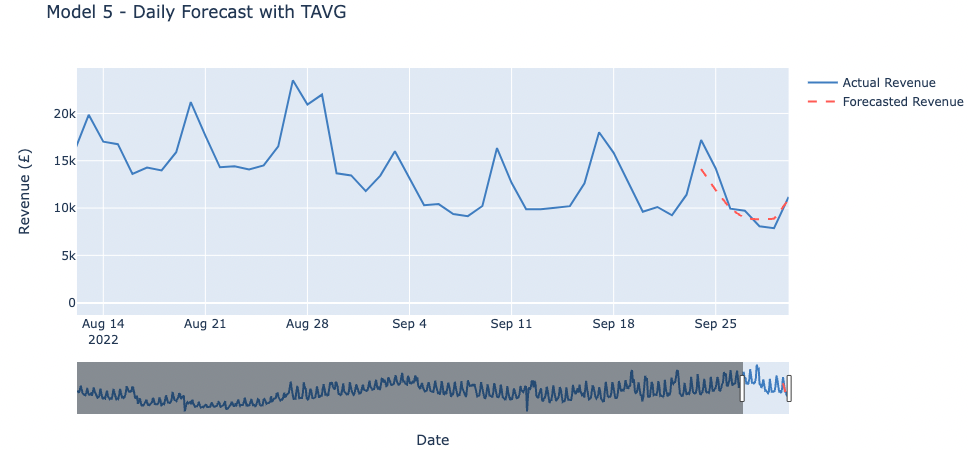

In [351]:
# To determine the accuracy of the results 
bakery.full_accuracy_report(prophet_test_daily['y'], forecast_daily_temp['yhat'], 'daily forecast')

The R2 for the daily forecast is: 0.756

The RMSE for the daily forecast is: 1556.21

The MAE between the actual and daily forecast revenue is 1169.94

The MAPE between the actual and daily forecast revenue is 9.5%


## Model 5 Accuracy Evaluation 
By adding the regressor the MAPE score decreased to the lowest score for the daily models. It did slightly decrease the R<sup>2</sup> value and increase the RMSE, however as discussed in earlier models the MAPE score is the most important accuracy metric. 

In [344]:
# To add the scores to the results table 
daily_model_scores = bakery.add_results(daily_model_scores, 5,
                                        0.756, 1556.21, 'N/A', '9.5%', 'TAVG added')

Model     R2     RMSE  AIC MAPE (%)                            Comments
0      1  0.756  1554.39  N/A    10.1%                      Baseline model
1      2  0.783  1466.62  N/A    10.6%         After tuning hyperparmeters
2      3  0.726  1649.40  N/A    11.0%                Adding Holiday Dates
3      4  0.773  1499.07  N/A    11.2%  Holidays and tuned hyperparameters
4      5  0.756  1556.21  N/A     9.5%                          TAVG added

# Determining the Best Daily Forecast
Reviewing the above results it appears that the best model is with default hyperparmeters, yearly and weekly seasonality set to True and a regressor of `TAVG` added, which scored a MAPE value of 9.5%. 

Despite the grid search beign applied on models 2 and 4 to tune the hyperparameters, they actually achieved worse accuracy scores. This is most likely due to overfitting on the train dataset. 

To further assess the accuracy and prediction from the model, the forecasted components will be explored with the `plot_components` method. 

# Visualising the Forecast Components of the Best Daily Model 
Now the most accurate daily model has been determined, the forecast components can be plotted. This includes the trend, yearly seasonality, weekly seasonality and regressor effect. 

Based on the EDA it is expected for the 7 day forecast for the end of September from the summer that there will be: 
- A downward trend for the 7 day forecast - due to the summer making the most revenue, and it gradually increase to a low in December 
- Weekly seasonal cycle, with the weekends having a greater revenue 
- Yearly seasonal cycle, with the summer months having a greater revenue 
- Regressor (`TAVG`) showing greatest effect on hotter days, which from the EDA correlated with greater revenue 

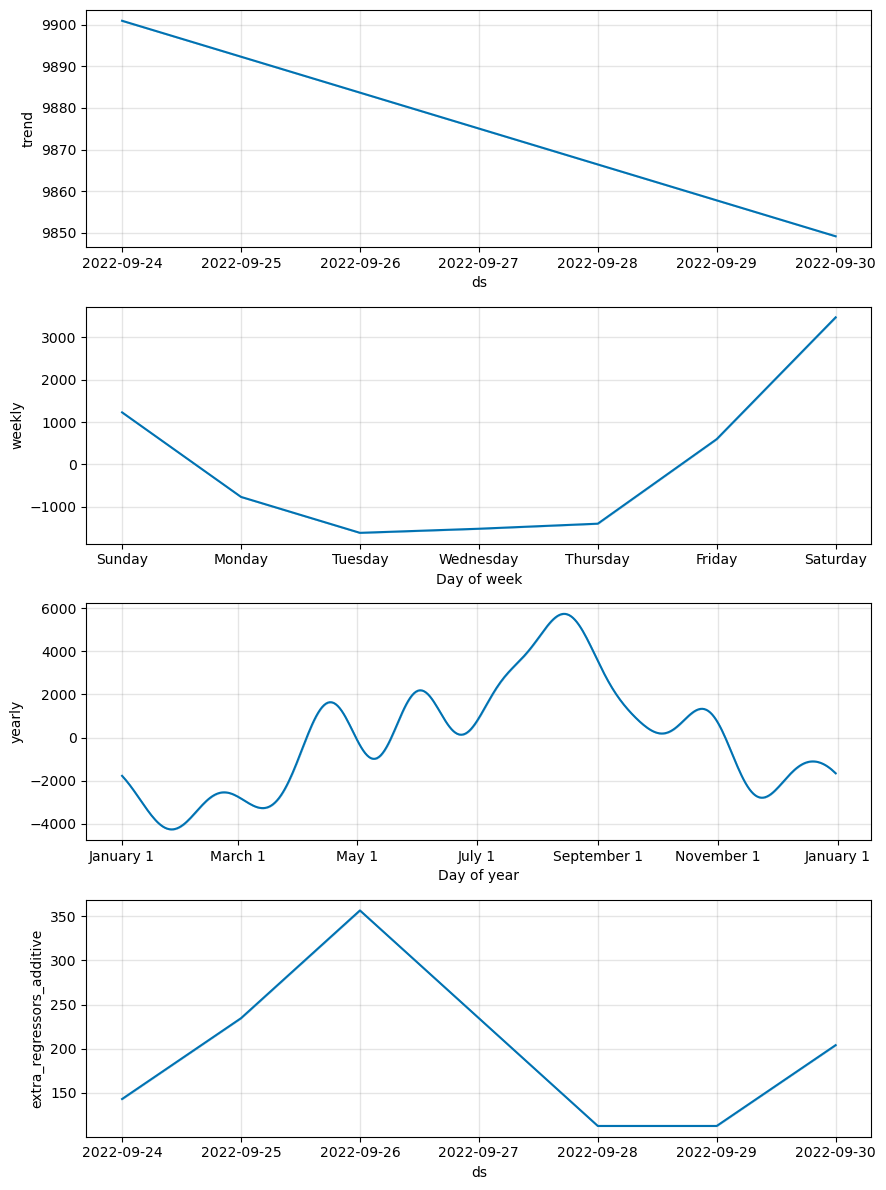

In [343]:
# To visualise the forecast components 
daily_plt = model_daily_reg.plot_components(forecast_daily_temp)

In [352]:
# To see the temperatures that correspond with the forecasted dates
future_temp

ds  TAVG
0 2022-09-24  24.0
1 2022-09-25  27.0
2 2022-09-26  31.0
3 2022-09-27  27.0
4 2022-09-28  23.0
5 2022-09-29  23.0
6 2022-09-30  26.0

## Observations From Component Plots
The above plot provides interesting insights.

- The first plot shows that the total daily revenue across the four bakeries to linearly decrease for the forecasted dates.

- The second plot highlights the fact that the weekly revenue is at it's lowest on Tuesday and peaks the end of the week and on the weekend.

- The third plot shows that the greatest revenue occurs during the holiday months of July and August. With additional peaks during April, October and June. These are most likely due to the school and bank holidays that generate more revenue than typical weeks. 

- The final extra_regressors_additive plot shows that there is an additional revenue generated due to the TAVG, peaking at £350 additional revenue on the 26th September. Looking at the above `future_temp` dataframe, it can be seen the the increased revenue forecasted in the plot correlates with increased temperature. 

---

# 2. Weekly Revenue Forecast
The above process of a baseline, grid search and adding holiday dates is repeated for the weekly forecast. 

First the dataset is set up with the correct column headers and then split into train and test sets as determined by the business, which is to predict the next 6 weeks of revenue.

*Therefore, anything on or before the date 2022-08-19 is the train dataset and on or post is test dataset.*

In [94]:
# Copy of the data is taken for audit trail purposes
prophet_full_weekly = total_rev.resample('W').sum().round(2).copy()
# Train dataset created 
prophet_full_weekly = prophet_full_weekly.reset_index()
# Columns are renamed to ds and y
prophet_full_weekly.rename(columns={'index': 'ds', 'Total_Revenue': 'y'}, inplace=True)
# To remove the last week which isn't a complete week
prophet_full_weekly = prophet_full_weekly[:-1]
# To validate it is in the correct format
prophet_full_weekly.tail()

ds          y
103 2022-08-28  118277.59
104 2022-09-04  103478.40
105 2022-09-11   78442.65
106 2022-09-18   86436.14
107 2022-09-25   84465.60

In [95]:
# Train dataset created 
prophet_train_weekly = prophet_full_weekly.loc[prophet_full_weekly.ds <= '2022-08-19']
# To validate it is in the correct format
prophet_train_weekly.tail()

ds          y
97  2022-07-17   90259.78
98  2022-07-24   98332.00
99  2022-07-31  112021.47
100 2022-08-07  109098.80
101 2022-08-14  106518.19

In [96]:
# Test dataset created 
prophet_test_weekly = prophet_full_weekly.loc[prophet_full_weekly.ds > '2022-08-19']
# To validate it is in the correct format
prophet_test_weekly.head(6)

ds          y
102 2022-08-21  113387.44
103 2022-08-28  118277.59
104 2022-09-04  103478.40
105 2022-09-11   78442.65
106 2022-09-18   86436.14
107 2022-09-25   84465.60

# Model 1 - Baseline Weekly Forecast
For the first baseline weekly forecast the model will be fitted with the default hyperparameters being set. This is expected to perform relatively well, based on the fact the daily baseline model was the second most accurate. However, only the yearly_seasonality will be set to True as the data will not show the weekly seasonality as it only shows data every week, not every day as required to determine the weekly seasonality. 

In [398]:
# First an empty results dataframe is created to track the accuracy of the models run
weekly_model_scores = pd.DataFrame()

In [393]:
model_weekly = Prophet(yearly_seasonality=True)
model_weekly.fit(prophet_train_weekly)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [394]:
# The dataframe for the required predicted dates is created with make_future_dataframe
future_weekly = model_weekly.make_future_dataframe(periods=6, freq='W', include_history=False)
future_weekly.head(6)

ds
0 2022-08-21
1 2022-08-28
2 2022-09-04
3 2022-09-11
4 2022-09-18
5 2022-09-25

In [395]:
# The dataframe is provided for the predictions
baseline_forecast_weekly = model_weekly.predict(future_weekly)
baseline_forecast_weekly[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds           yhat     yhat_lower     yhat_upper
1 2022-08-28  111787.546886  101467.657920  122214.838199
2 2022-09-04  105898.226112   96098.781766  115493.157951
3 2022-09-11  101026.681205   90973.783122  110860.349494
4 2022-09-18   96572.549420   86818.227644  107289.823009
5 2022-09-25   91361.309744   81882.509622  101476.014675

In [396]:
# To visualise the forecasted vs actual weekly revenue 
fig = go.Figure()
fig.add_trace(go.Scatter(x=prophet_full_weekly['ds'], y=prophet_full_weekly['y'], mode='lines', name='Actual Revenue',
              line={'color' : bakery.light_magpie}))
fig.add_trace(go.Scatter(x=baseline_forecast_weekly['ds'], y=baseline_forecast_weekly['yhat'], mode='lines', 
                         name='Forecasted Revenue',
                         line={'dash': 'dash', 'color': bakery.red_magpie}))

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    yaxis_title='Revenue (£)', 
    xaxis_title='Date',
    legend_title='',
    title='Model 1 - Baseline Weekly Forecast')
# fig.write_image('fbblank.png', scale=2)
fig.show()

*Image of the above plotly graph for model 1 weekly forecast:*
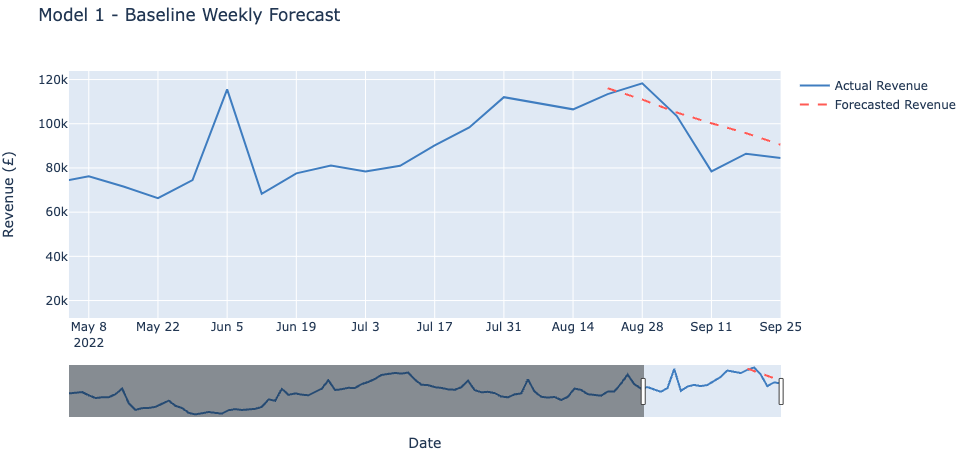

In [399]:
# To determine the accuracy of the baseline model 
bakery.full_accuracy_report(prophet_test_weekly['y'], baseline_forecast_weekly['yhat'], 'weekly forecast')

The R2 for the weekly forecast is: 0.477

The RMSE for the weekly forecast is: 10951.3

The MAE between the actual and weekly forecast revenue is 8647.27

The MAPE between the actual and weekly forecast revenue is 9.9%


In [400]:
# To add the scores to the results table 
weekly_model_scores = bakery.add_results(weekly_model_scores, 1,
                                        0.477, 10951.3, 'N/A', '9.9%', 'Baseline weekly forecast')

Model     R2     RMSE  AIC MAPE (%)                  Comments
0      1  0.477  10951.3  N/A     9.9%  Baseline weekly forecast

### Evaluation of Model 1 Weekly Baseline
From the above results and graph it can be seen that the weekly forecast is fitted relatively well to the actual revenue, with a MAPE score of 9.9%, and in fact lower than the best daily forecasted model. This could be due to the fact the weekly revenue is more smoothed and has less fluctuations than the daily revenue, making it simpler to forecast. 

To further try and improve the results a grid search will be conducted to try and determine the optimal tuned hyperparameters. 

---

# Hyperparameter Tuning
To find the optimal hyperparameters required for the weekly model the cross validation method is used. For the cross validation, the models will be trained on the initial first 500 days, and forecast the next 6 weeks (42 days). It then adds 1 week worth of data and forecasts the next 6 weeks, and repeats this until there is no more train data remaining. 

**N.B** *The following two block cells for the grid search and determining best hyperparameters have been commented out to reduce run time. An image of the results can be found below.*

In [368]:
# # The parameter grid is set up with the values being tested for each parameter 
# param_grid = {  
#     'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
#     'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]}

# # The zip is used to generate all combinations of parameters
# all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

# # Store the RMSEs for each params here
# rmses = [] 

# # Use cross validation to evaluate all parameters
# for params in all_params:
#     # Fit model with given params
#     m = Prophet(**params, yearly_seasonality=True).fit(prophet_train_weekly)
#     df_cv = cross_validation(m, initial = '500 days', period = '7 days', horizon='42 days', parallel='processes')
#     df_p = performance_metrics(df_cv, rolling_window=1)
#     rmses.append(df_p['rmse'].values[0])

In [202]:
# # Best hyperparameters
# best_params = all_params[np.argmin(rmses)]
# print(f'The optimum hyperparameters are: {best_params}')
# print('')
# best_rmse = np.argmin(rmses)
# print(f'The lowest RMSE is: {round(rmses[best_rmse],2)}')

The optimum hyperparameters are: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1}

The lowest RMSE is: 14068.77


*Results from the grid search on the weekly dataset* 
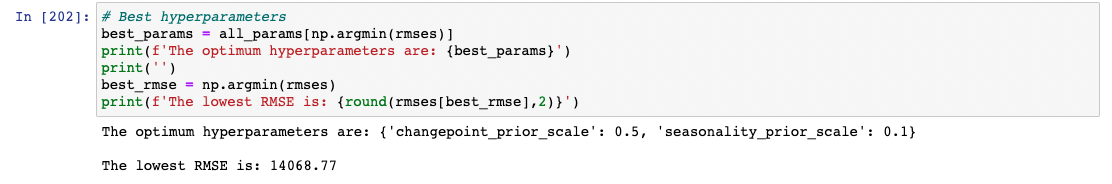

# Model 2 - Fitting the Model with the Tuned Hyperparameters 
Now the best hyperparameters have been determined, the model can be fitted on the train weekly data.

In [204]:
model = Prophet(yearly_seasonality=True,
                      changepoint_prior_scale=0.5,seasonality_prior_scale=0.1)
model.fit(prophet_train_weekly)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [205]:
# To provide a dataframe for the predict method, containing a `ds` column
forecast_weekly = model.predict(future_weekly)
forecast_weekly[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds          yhat    yhat_lower     yhat_upper
1 2022-08-28  93384.322763  84702.037503  101581.962281
2 2022-09-04  84215.555440  75321.312417   92294.843824
3 2022-09-11  77748.698566  69278.050620   86570.543248
4 2022-09-18  72788.802594  63906.051278   81794.612812
5 2022-09-25  67202.775693  58940.006688   75442.611033

In [369]:
# To plot the actual vs forecast weekly revenue 
fig = go.Figure()
# Add actual vs forecasted revenue 
fig.add_trace(go.Scatter(x=prophet_full_weekly['ds'], y=prophet_full_weekly['y'], mode='lines', name='Actual Revenue',
              line={'color' : bakery.light_magpie}))
fig.add_trace(go.Scatter(x=forecast_weekly['ds'], y=forecast_weekly['yhat'], mode='lines', name='Forecasted Revenue',
                         line={'dash': 'dash', 'color': bakery.red_magpie}))

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    yaxis_title='Revenue (£)',
    xaxis_title='Date',
    legend_title='',
    title='Model 2 - Weekly Forecast with Tuned Hyperparameters')
# fig.write_image('fbblank.png', scale=2)
fig.show()

*Image of the above plotly graph for model 2 weekly forecast:*
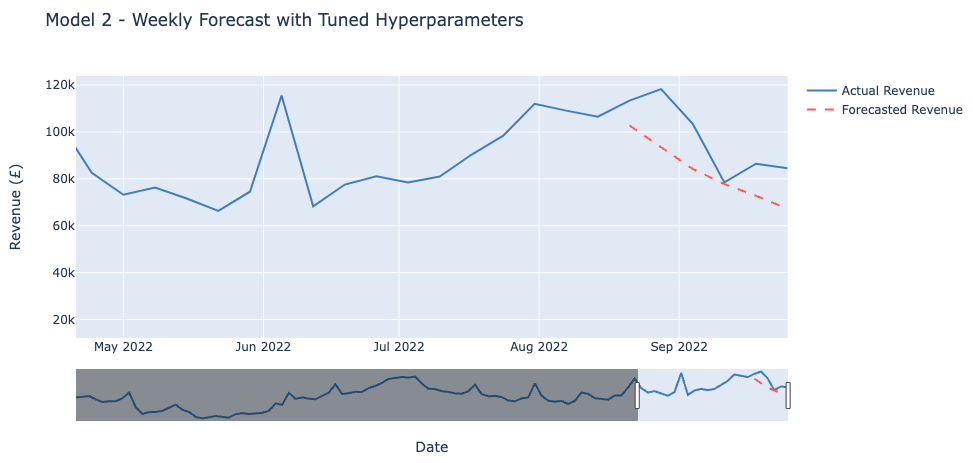

In [208]:
# To evaluate the accuracy of the model 
bakery.full_accuracy_report(prophet_test_weekly['y'], forecast_weekly['yhat'], 'weekly forecast')

The R2 for the weekly forecast is: -0.155

The RMSE for the weekly forecast is: 16267.84

The MAE between the actual and weekly forecast revenue is 14393.58

The MAPE between the actual and weekly forecast revenue is 14.4%


### Evaluation of Model 2 Weekly with Tuned Hyperparameters
Similar to the daily forecast, by using hyperparameters out of the grid search, the model produced actually had a worse accuracy score. This is most likely due to the model overfitting on the train dataset, due to the validation and train data being used and therefore performing worse in the real-world. 

To further try and improve the results the holiday days will be added to the model.

In [401]:
# To add the scores to the results table 
weekly_model_scores = bakery.add_results(weekly_model_scores, 2,
                                        -0.155, 16267.84, 'N/A', '14.4%', 'Tuned hyperparameters')

Model     R2      RMSE  AIC MAPE (%)                  Comments
0      1  0.477  10951.30  N/A     9.9%  Baseline weekly forecast
1      2 -0.155  16267.84  N/A    14.4%     Tuned hyperparameters

# Model 3 - Baseline Weekly Revenue Forecast with Holidays
The above process will now be repeated except with holiday days added. For the baseline model the default hyperparameters will be used. 

In [374]:
model_hols = Prophet(yearly_seasonality=True, holidays=holidays_train)
model_hols.fit(prophet_train_weekly)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [375]:
# To provide a dataframe for the predict method, it must also contain a `ds` column
baseline_forecast_hols = model_hols.predict(future_weekly)
baseline_forecast_hols[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds           yhat     yhat_lower     yhat_upper
1 2022-08-28  114243.167242  104943.458467  123250.864444
2 2022-09-04  111249.197959  102185.545342  120888.552493
3 2022-09-11   99321.675790   90038.396757  108987.377360
4 2022-09-18   95856.352638   86163.869262  105011.743329
5 2022-09-25   90909.129407   81620.176516  100630.171928

In [376]:
# To plot the actual vs forecasted revenue with special dates
fig = go.Figure()
# Add actual vs forecasted revenue 
fig.add_trace(go.Scatter(x=prophet_full_weekly['ds'], y=prophet_full_weekly['y'], mode='lines', name='Actual Revenue',
              line={'color' : bakery.light_magpie}))
fig.add_trace(go.Scatter(x=baseline_forecast_hols['ds'], y=baseline_forecast_hols['yhat'], mode='lines', 
                         name='Forecasted Revenue',
                         line={'dash': 'dash', 'color': bakery.red_magpie}))

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    yaxis_title='Revenue (£)', 
    xaxis_title='Date',
    legend_title='',
    title='Model 3 - Baseline Weekly Forecast with Special Dates')
# fig.write_image('fbblank.png', scale=2)
fig.show()

*Image of the above plotly graph for model 3 weekly forecast:*
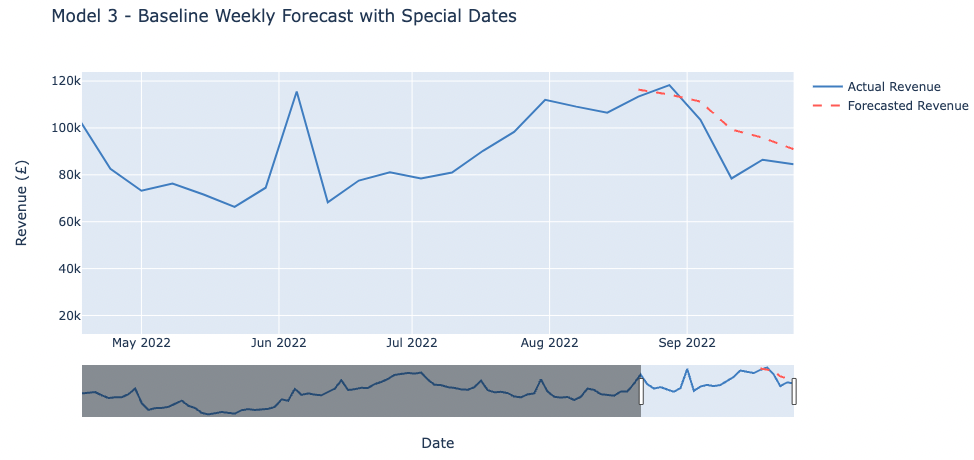

In [377]:
# To evaluate the accuracy of the model 
bakery.full_accuracy_report(prophet_test_weekly['y'], baseline_forecast_hols['yhat'], 'weekly forecast')

The R2 for the weekly forecast is: 0.526

The RMSE for the weekly forecast is: 10420.7

The MAE between the actual and weekly forecast revenue is 8582.66

The MAPE between the actual and weekly forecast revenue is 9.8%


### Evaluation of Model 3 Weekly with Tuned Hyperparameters
This improved the results from model 2 and the original baseline model, showing that holidays dataframe being added to have an affect on the model and predictions. 

To further try and improve a grid search will be carried out on the weekly data with the holiday days added.

In [402]:
# To add the scores to the results table 
weekly_model_scores = bakery.add_results(weekly_model_scores, 3,
                                        0.526, 10420.7, 'N/A', '9.8%', 'Baseline with holidays')

Model     R2      RMSE  AIC MAPE (%)                  Comments
0      1  0.477  10951.30  N/A     9.9%  Baseline weekly forecast
1      2 -0.155  16267.84  N/A    14.4%     Tuned hyperparameters
2      3  0.526  10420.70  N/A     9.8%    Baseline with holidays

# Tuning the Hyperparameters for the Weekly Forecast with Holidays
As with the daily model forecast, the weekly forecast will  be cross validated in a grid search to try and tune the hyperparmeters with the holiday dataframe added. Based on the previous grid searches, this is not expected to improve the model too much. 

**N.B** *The following code blocks have been commented out to reduce run-time. A screenshot of the results is included below.*

In [372]:
# # Gird search and cross validation is performed with holidays added 
# param_grid = {  
#     'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
#     'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
# #     'seasonality_mode': ['additive', 'multiplicative'],
#     'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0]
# }

# # Generate all combinations of parameters
# holiday_all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# holiday_rmses = []  # Store the RMSEs for each params here


# # Use cross validation to evaluate all parameters
# for params in holiday_all_params:
#     # Fit model with given params
#     m = Prophet(**params,holidays=holidays_train,
#                 yearly_seasonality=True).fit(prophet_train_weekly) 
#     df_cv_hol = cross_validation(m, initial = '500 days', period = '7 days', horizon='42 days', parallel='processes')
#     df_p = performance_metrics(df_cv_hol, rolling_window=1)
#     holiday_rmses.append(df_p['rmse'].values[0])

In [373]:
# # Best hyperparameters for best RMSE
# holiday_best_params = holiday_all_params[np.argmin(holiday_rmses)]
# print(holiday_best_params)
# holiday_best_rmse = np.argmin(holiday_rmses)
# print(f'The lowest rmse is: {round(holiday_rmses[holiday_best_rmse],2)}')

Image of the output from the above grid search with holidays added: 

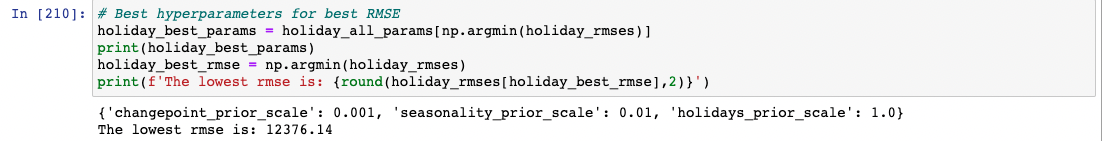

# Model 4 - Weekly Forecast with Holidays and Tuned Hyperparameters
The next model will now be re-run with the tuned hyperparameters. 

In [389]:
model_hols = Prophet(yearly_seasonality=True, holidays=holidays_train,
                     changepoint_prior_scale= 0.001, seasonality_prior_scale= 0.01, holidays_prior_scale= 1)
model_hols.fit(prophet_train_weekly)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [390]:
# To provide a dataframe for the predict method, containing a `ds` column
forecast_hols = model_hols.predict(future_weekly)
forecast_hols[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds           yhat    yhat_lower     yhat_upper
1 2022-08-28  100407.943046  81042.452349  119986.514870
2 2022-09-04  101314.659256  81175.942270  121554.052013
3 2022-09-11   89086.440032  68964.931466  109213.808303
4 2022-09-18   89432.710821  69416.956546  108200.228174
5 2022-09-25   88830.154052  69738.316511  109959.423394

In [391]:
fig = go.Figure()

# Add actual vs forecasted revenue 
fig.add_trace(go.Scatter(x=prophet_full_weekly['ds'], y=prophet_full_weekly['y'], mode='lines', name='Actual Revenue'))
fig.add_trace(go.Scatter(x=forecast_hols['ds'], y=forecast_hols['yhat'], mode='lines', name='Forecasted Revenue',
                         line={'dash': 'dash', 'color': 'red'}))

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    yaxis_title='Revenue (£)', 
    xaxis_title='Date',
    legend_title='',
    title='Model 4 - Weekly Forecast with Special Days and Tuned Hyperparameters')

# fig.write_image('fbblank.png', scale=2)
fig.show()

*Image of the above plotly graph for model 4 weekly forecast*
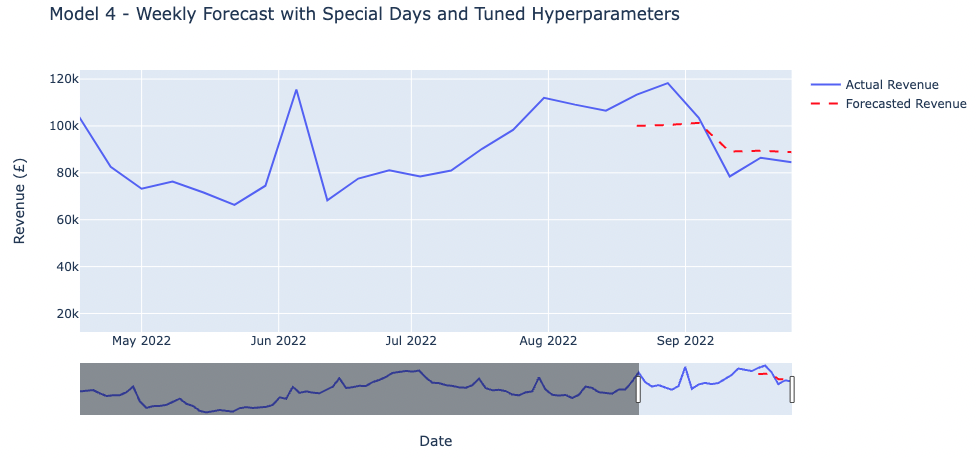

In [392]:
# To assess the accuracy of the model 
bakery.full_accuracy_report(prophet_test_weekly['y'], forecast_hols['yhat'], 'weekly forecast')

The R2 for the weekly forecast is: 0.532

The RMSE for the weekly forecast is: 10358.48

The MAE between the actual and weekly forecast revenue is 8566.22

The MAPE between the actual and weekly forecast revenue is 8.5%


### Evaluation of Model 4 Weekly with Tuned Hyperparameters
This improved the results to achieve the lowest MAPE score. In addition to this, it can be seen in the graph, that the forecasted revenue accurately predicts the decrease in revenue post 4th September 2022, which is due to the school holidays ending. This shows that adding the holiday dataframe did in fact improve the accuracy of the model for the weekly revenue. 

In [403]:
# To add the scores to the results table 
weekly_model_scores = bakery.add_results(weekly_model_scores, 4,
                                        0.532, 10358.55, 'N/A', '8.5%', 'Holidays and tuned hyperparameters')

Model     R2      RMSE  AIC MAPE (%)                            Comments
0      1  0.477  10951.30  N/A     9.9%            Baseline weekly forecast
1      2 -0.155  16267.84  N/A    14.4%               Tuned hyperparameters
2      3  0.526  10420.70  N/A     9.8%              Baseline with holidays
3      4  0.532  10358.55  N/A     8.5%  Holidays and tuned hyperparameters

# Determining the Best Weekly Forecast
Reviewing the above results it appears that the best model is model 4, with the holidays dataframe added and tuned hyperparameters post the grid search. The holiday dataframe perhaps had a greater impact on the weekly forecast over the daily forecast, as the forecasted dates (6 weeks) included a mixture of School Holidays and non-school holidays. Whereas, the daily forecast was for non-school holidays only, therefore adding the holiday dataframe did not improve the accuracy. 

The two baseline models, with no hyperparameter tuning got the 2nd and 3rd best accuracy scores, similar to the daily revenue forecast. 

To further assess the accuracy and prediction from the model, the forecasted components will be explored with the `plot_components` method.

---

# Visualising the Weekly Forecast Components
The components plot for the optimial weekly forecast includes the trend, holiday effect, yearly seasonality and weekly seasonality.  

Based on the EDA it is expected for the 6 week forecast from August into September is: 
- A slight upwards trend as August is the peak revenue month for the bakeries, however not too extreme as the forecast heads into September where revenue generally decreases again 
- A holiday affect impacting the first half of the forecast as this accounts for dates in the Summer Holidays, and then decreasing in September 
- Yearly seasonal cycle, with the summer months having a greater revenue 

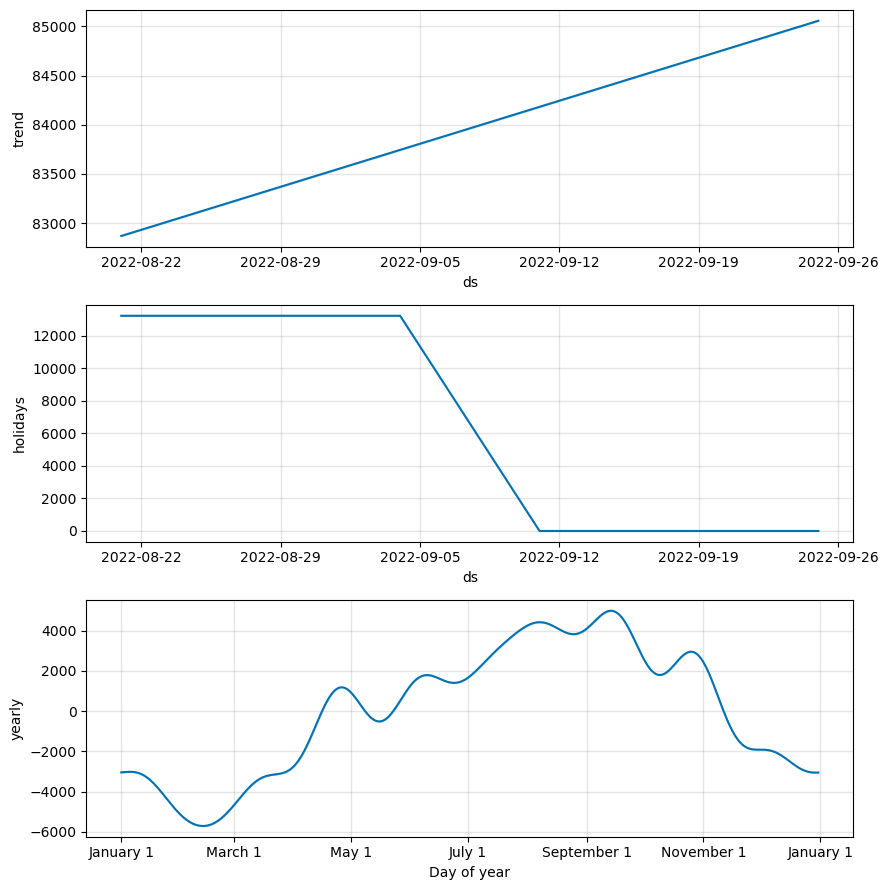

In [404]:
plt_weekly = model_hols.plot_components(forecast_hols)

## Observations From Component Plots
The above plots confirm the hypotheses made:
- Weekly revenue has a general upwards trend for the forecasted dates
- The holiday affect is an increase of £12,000 on days that fall in the School Holidays
- There is a yearly cycle, with peaks over the summer months and additional peaks in April and October (most likely due to the School Holidays then). However, unexpectedly the largest increase in the yearly cycle is during September, whereas in the Daily and from experience it falls in August. This could be predicted as a delayed peak at the end of the summer holidays. 
---

# 3. Monthly Revenue Forecast
The above process of a baseline, grid search and adding holiday dates is repeated for the weekly forecast. 

First the data is set up with the correct column names, resampled to monthly and split into train and test sets as determined by the business, which is to predict the next 6 months of revenue.

*Therefore, anything on or before the date 01-03-2022 is the train dataset and on or post is test dataset.*

In [161]:
# Copy of the data is taken for audit trail purposes
prophet_full_monthly = total_rev.resample('MS').sum().round(2).copy()
# Train dataset created 
prophet_full_monthly = prophet_full_monthly.reset_index()
# Columns are renamed to ds and y
prophet_full_monthly.rename(columns={'index': 'ds', 'Total_Revenue': 'y'}, inplace=True)
# To validate it is in the correct format
prophet_full_monthly.head()

ds          y
0 2020-09-01  271314.93
1 2020-10-01  267385.25
2 2020-11-01  143635.13
3 2020-12-01  173145.73
4 2021-01-01   95207.98

In [162]:
# Train dataset created 
prophet_train_monthly = prophet_full_monthly.loc[prophet_full_monthly.ds <= '2022-03-01']
# To validate it is in the correct format
prophet_train_monthly.tail()

ds          y
14 2021-11-01  278913.34
15 2021-12-01  285428.48
16 2022-01-01  265070.84
17 2022-02-01  248737.03
18 2022-03-01  266550.35

In [163]:
# Train dataset created 
prophet_test_monthly = prophet_full_monthly.loc[prophet_full_monthly.ds > '2022-03-01']
# To validate it is in the correct format
prophet_test_monthly.tail()

ds          y
20 2022-05-01  332789.82
21 2022-06-01  351262.48
22 2022-07-01  422977.42
23 2022-08-01  496394.56
24 2022-09-01  350491.42

# Model 1 - Baseline Monthly Forecast
For the baseline monthly forecast no parameter tuning will occur, only the yearly_seasonality set to True, as this should still be detected from the monthly revenue. 

In [405]:
# First an empty results dataframe is created to track the accuracy of the models run
monthly_model_scores = pd.DataFrame()

In [406]:
# To fit the model with only the yearly seasonality set to True
model_monthly_baseline = Prophet(yearly_seasonality=True)
model_monthly_baseline.fit(prophet_train_monthly)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


In [414]:
# To create the dataframe with the dates that need to be forecasted
future_monthly = model_monthly_baseline.make_future_dataframe(periods=6, freq='MS', include_history=False)
future_monthly

ds
0 2022-04-01
1 2022-05-01
2 2022-06-01
3 2022-07-01
4 2022-08-01
5 2022-09-01

In [408]:
# To predict using the baseline model 
forecast_baseline = model_monthly_baseline.predict(future_monthly)
forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds           yhat     yhat_lower     yhat_upper
1 2022-05-01  180696.559151  157274.150709  207353.295741
2 2022-06-01  465104.978284  412770.401219  517998.097450
3 2022-07-01  790314.894656  708837.765181  877027.591568
4 2022-08-01  753297.816527  629017.982605  879349.645530
5 2022-09-01  455348.424605  281475.891968  624822.898290

In [412]:
# To visualise the baseline monthly forecast
fig = go.Figure()

# Add actual vs forecasted revenue \n",
fig.add_trace(go.Scatter(x=prophet_full_monthly['ds'], y=prophet_full_monthly['y'], mode='lines',
                         name='Actual Revenue',
              line={'color' : bakery.light_magpie}))
fig.add_trace(go.Scatter(x=forecast_baseline['ds'], y=forecast_baseline['yhat'], mode='lines',
                         name='Forecasted Revenue',
                         line={'dash': 'dash', 'color': bakery.red_magpie}))

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    yaxis_title='Revenue (£)', 
    xaxis_title='Date',
    legend_title='',
    title='Model 1 - Baseline Monthly Forecast')

fig.show()

*Image of the above plotly graph for model 1 monthly forecast*
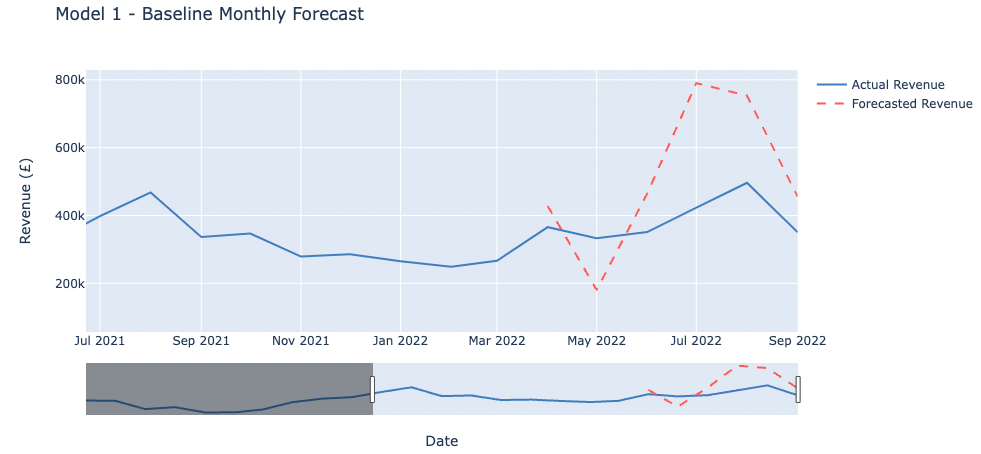

In [416]:
bakery.full_accuracy_report(prophet_test_monthly['y'], forecast_baseline['yhat'], 'monthly forecast')

The R2 for the monthly forecast is: -12.079

The RMSE for the monthly forecast is: 204917.45

The MAE between the actual and monthly forecast revenue is 176278.44

The MAPE between the actual and monthly forecast revenue is 44.0%


### Evaluation of Model 1 Monthly Baseline
The above baseline monthly model produced a very inaccurate forecast, with a negative R<sup>2</sup> value and a high MAPE score of 44.0%. This is most likely due to the significant decrease in train data points compared to the daily or weekly forecasts. 

To try and improve the results a grid search will be conducted to try and determine the optimal tuned hyperparameters. 

---

In [415]:
# To add the scores to the results table 
monthly_model_scores = bakery.add_results(monthly_model_scores, 1,
                                        -12.079, 204917.45, 'N/A', '44.0%', 'Baseline monthly forecast')

Model      R2       RMSE  AIC MAPE (%)                   Comments
0      1 -12.079  204917.45  N/A    44.0%  Baseline monthly forecast

# Hyperparameter Tuning
To find the optimal hyperparameters required for the monthly model the cross validation method is used. For the cross validation, the models will forecast the next month (30 days), and the horizon and period will be left to defaul, which is horizon is 3 times the forecast period, and period is half the forecast period. This was left as there were too few data points in the dataset to set similar parameters as the Daily and Weekly.

**N.B** *The following two block cells for the grid search and determining best hyperparameters have been commented out to reduce run time. An image of the results can be found below.*

In [417]:
# # Gird search and cross validation is performed with holidays added 
# param_grid = {  
#     'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
#      'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
# #      'seasonality_mode': ['additive', 'multiplicative']
# }

# # Generate all combinations of parameters
# all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# rmses = []  # Store the RMSEs for each params here


# # Use cross validation to evaluate all parameters
# for params in all_params:
#     # Fit model with given params
#     m = Prophet(**params,
#                 yearly_seasonality=True,).fit(prophet_train_monthly) 
#     df_cv = cross_validation(m, horizon='30 days', parallel='processes')
#     df_p = performance_metrics(df_cv, rolling_window=1)
#     rmses.append(df_p['rmse'].values[0])

In [243]:
# # Best hyperparameters
# best_params = all_params[np.argmin(rmses)]
# print(f'The optimum hyperparameters are: {best_params}')
# print('')
# best_rmse = np.argmin(rmses)
# print(f'The lowest RMSE is: {round(rmses[best_rmse],2)}')

The optimum hyperparameters are: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1}

The lowest RMSE is: 45022.27


Results from the above grid search: 

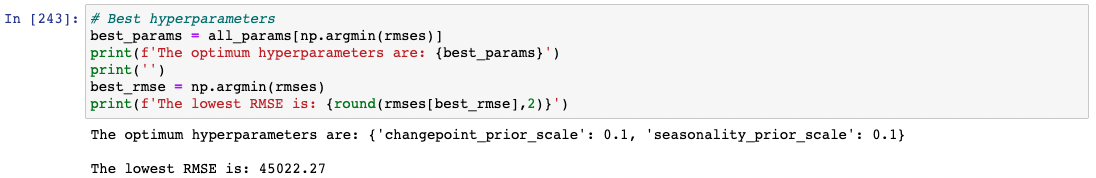

## Model 2 - Monthly Forecast with Tuned Hyperparameters 
Now the best hyperparameters have been determined, the model can be fitted on the train data.

In [420]:
# to fit the model 
model = Prophet(yearly_seasonality=True, changepoint_prior_scale=0.1,seasonality_prior_scale=0.1)
model.fit(prophet_train_monthly)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


In [421]:
# to make the prediction
forecast_monthly = model.predict(future_monthly)
forecast_monthly[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds           yhat     yhat_lower     yhat_upper
1 2022-05-01  446680.354227  438691.256216  454892.981827
2 2022-06-01  470017.904299  460556.936602  479055.320130
3 2022-07-01  546880.586349  535203.978508  558149.650567
4 2022-08-01  615657.577696  601642.881056  629098.747665
5 2022-09-01  485440.084729  467943.436000  503702.512507

In [423]:
# To plot the actual vs monthly forecast 
fig = go.Figure()

# Add actual vs forecasted revenue 
fig.add_trace(go.Scatter(x=prophet_full_monthly['ds'], y=prophet_full_monthly['y'], mode='lines', 
                         name='Actual Revenue',
              line={'color' : bakery.light_magpie}))
fig.add_trace(go.Scatter(x=forecast_monthly['ds'], y=forecast_monthly['yhat'], mode='lines', name='Forecasted Revenue',
                         line={'dash': 'dash', 'color': bakery.red_magpie}))

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    yaxis_title='Revenue (£)',
    xaxis_title='Date',
    legend_title='',
    title='Model 2 - Monthly Forecast Tuning Hyperparameters')
fig.show()

*Image of the above plotly graph for model 2 monthly forecast*
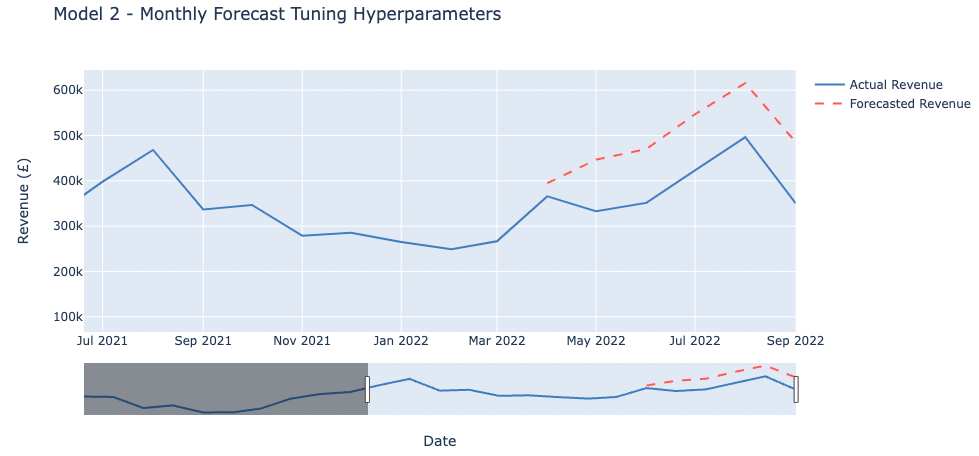

In [252]:
# To determine the accuracy of the model 
bakery.full_accuracy_report(prophet_test_monthly['y'], forecast_monthly['yhat'], 'monthly forecast')

The R2 for the monthly forecast is: -2.93

The RMSE for the monthly forecast is: 112328.23

The MAE between the actual and monthly forecast revenue is 106638.5

The MAPE between the actual and monthly forecast revenue is 28.0%


### Evaluation of Model 2 Monthly with Tuned Hyperparameters
Unlike the daily and weekly forecasts, the hyperparameter tuning improved the accuracy results dramatically compared to the baseline model. However, the R<sup>2</sup> score is still negative and the MAPE score is still too high to be deemed a suitable and accurate model. 

To further try and improve the results the holiday days will be added to the model.

In [424]:
# To add the scores to the results table 
monthly_model_scores = bakery.add_results(monthly_model_scores, 2,
                                         -2.93, 112328.23, 'N/A', '28.0%', 'Tuned hyperparameters')

Model      R2       RMSE  AIC MAPE (%)                   Comments
0      1 -12.079  204917.45  N/A    44.0%  Baseline monthly forecast
1      2  -2.930  112328.23  N/A    28.0%      Tuned hyperparameters

# Model 3 - Baseline Monthly Revenue Forecast with Holidays
The above process will now be repeated except with holiday days added.

In [425]:
# To fit the model with holidays added
model_hols = Prophet(yearly_seasonality=True, holidays=holidays_train)
model_hols.fit(prophet_train_monthly)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


In [426]:
# To make the prediction
baseline_forecast_hols = model_hols.predict(future_monthly)
baseline_forecast_hols[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds           yhat     yhat_lower     yhat_upper
1 2022-05-01  437774.089073  437774.053691  437774.124127
2 2022-06-01  442856.571431  442856.501371  442856.640996
3 2022-07-01  443581.973358  443581.859782  443582.083253
4 2022-08-01  844438.389370  844438.230153  844438.537776
5 2022-09-01  498233.164835  498232.941078  498233.363479

In [428]:
# To plot the actual vs predicted revenue for monthly 
fig = go.Figure()
# Add actual vs forecasted revenue 
fig.add_trace(go.Scatter(x=prophet_full_monthly['ds'], y=prophet_full_monthly['y'], mode='lines', 
                         name='Actual Revenue',
              line={'color' : bakery.light_magpie}))
fig.add_trace(go.Scatter(x=baseline_forecast_hols['ds'], y=baseline_forecast_hols['yhat'], mode='lines', 
                         name='Forecasted Revenue',
                         line={'dash': 'dash', 'color': bakery.red_magpie}))

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    yaxis_title='Revenue (£)', 
    xaxis_title='Date',
    legend_title='',
    title='Model 3 - Baseline Monthly Forecasted Revenue with Holidays' )
fig.show()

*Image of the above plotly graph for model 2 monthly forecast*
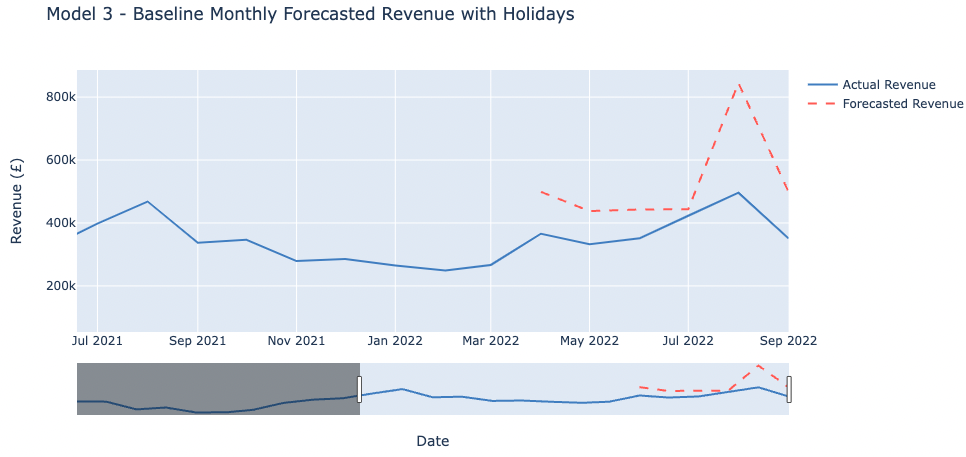

In [257]:
# To calculate the accuracy metrics of the model 
bakery.full_accuracy_report(prophet_test_monthly['y'], baseline_forecast_hols['yhat'], 'monthly forecast')

The R2 for the monthly forecast is: -8.373

The RMSE for the monthly forecast is: 173478.43

The MAE between the actual and monthly forecast revenue is 141045.9

The MAPE between the actual and monthly forecast revenue is 35.2%


### Evaluation of Model 3 Monthly with Tuned Hyperparameters
By adding the holiday dates, this decreased the accuracy of the model compared to model 2. This could be due to the model unsure where to add the holiday affect when the holiday falls in only part or a small section of the month. From the graph it can be seen that by adding the holiday dates there is a huge spike in August where it is perhaps predicting too much due to the summer holidays.

To try and improve a grid search will be carried out on the weekly data with the holiday days added.

In [436]:
# To add the scores to the results table 
monthly_model_scores = bakery.add_results(monthly_model_scores, 3,
                                         -8.373, 173478.43, 'N/A', '35.2%', 'Baseline with holidays')

Model      R2       RMSE  AIC MAPE (%)                   Comments
0      1 -12.079  204917.45  N/A    44.0%  Baseline monthly forecast
1      2  -2.930  112328.23  N/A    28.0%      Tuned hyperparameters
2      3  -8.373  173478.43  N/A    35.2%     Baseline with holidays

## Tuning Hyperparameters with Holidays
As with the daily and weekly model forecast, the monthly forecast will  be cross validated in a grid search to try and tune the hyperparmeters with the holiday dataframe added. 

**N.B** *The following code blocks have been commented out to reduce run-time. A screenshot of the results is included below.*

In [429]:
# # Gird search and cross validation is performed with holidays added 
# param_grid = {  
#     'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
#      'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
#     'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0]
# }

# # Generate all combinations of parameters
# holiday_all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# holiday_rmses = []  # Store the RMSEs for each params here

# # Use cross validation to evaluate all parameters
# for params in holiday_all_params:
#     # Fit model with given params
#     m = Prophet(**params,holidays=holidays_train,
#                 yearly_seasonality=True,).fit(prophet_train_monthly) 
#     df_cv_hol = cross_validation(m, horizon='30 days', parallel='processes')
#     df_p = performance_metrics(df_cv_hol, rolling_window=1)
#     holiday_rmses.append(df_p['rmse'].values[0])


# # Find the best parameters
# hol_tuning_results = pd.DataFrame(holiday_all_params)
# hol_tuning_results['rmse'] = holiday_rmses

In [259]:
# Best hyperparameters
best_params = holiday_all_params[np.argmin(holiday_rmses)]
print(f'The optimum hyperparameters are: {best_params}')
print('')
best_rmse = np.argmin(holiday_rmses)
print(f'The lowest RMSE is: {round(holiday_rmses[best_rmse],2)}')

The optimum hyperparameters are: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01}

The lowest RMSE is: 27136.3


*An image of the above results from the grid search for the best hyperparameters and lowest RMSE :*
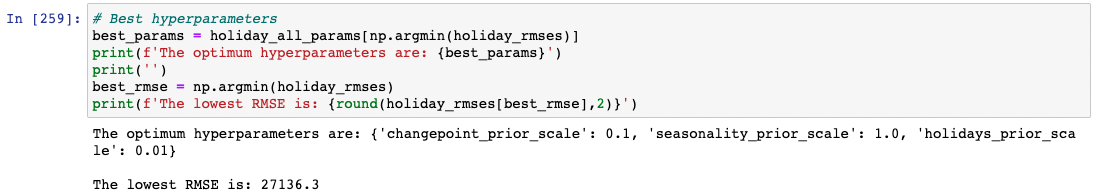

# Model 4 - Monthly Forecast with Tuned Hyperparameters and Holidays
The model will now be fitted with the above determined hyperparameters. 

In [430]:
# To fit the model 
model_hols = Prophet(yearly_seasonality=True, holidays=holidays_train,
                     changepoint_prior_scale= 0.1, seasonality_prior_scale= 1.0, holidays_prior_scale= 0.01)
model_hols.fit(prophet_train_monthly)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


In [431]:
# To get the predicted revenue
forecast_hols = model_hols.predict(future_monthly)
forecast_hols[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds           yhat     yhat_lower     yhat_upper
1 2022-05-01  508275.402539  504338.889098  511428.000397
2 2022-06-01  497278.748808  489595.403572  503979.482788
3 2022-07-01  609362.751353  597611.196437  620151.935900
4 2022-08-01  672819.208780  655179.027752  688509.505312
5 2022-09-01  498185.416918  474530.099876  518958.563668

In [433]:
fig = go.Figure()

# Add actual vs forecasted revenue 
fig.add_trace(go.Scatter(x=prophet_full_monthly['ds'], y=prophet_full_monthly['y'], mode='lines',
                         name='Actual Revenue', line={'color': bakery.light_magpie}))
fig.add_trace(go.Scatter(x=forecast_hols['ds'], y=forecast_hols['yhat'], mode='lines', name='Forecasted Revenue',
                         line={'dash': 'dash', 'color': 'red'}))

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    yaxis_title='Revenue (£)', 
    xaxis_title='Date',
    legend_title='',
    title='Model 4 - Monthly Forecast with Holidays and Tuned Hyperparameters' )
fig.show()

*Image of the above plotly graph for model 4 monthly forecast*
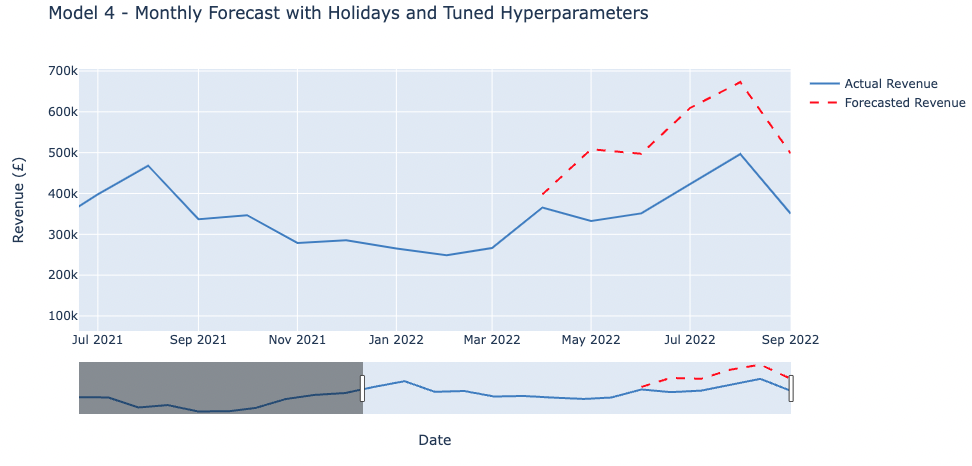

In [266]:
# To evaluate the model 
bakery.full_accuracy_report(prophet_test_monthly['y'], forecast_hols['yhat'], 'monthly forecast')

The R2 for the monthly forecast is: -6.31

The RMSE for the monthly forecast is: 153199.17

The MAE between the actual and monthly forecast revenue is 144004.38

The MAPE between the actual and monthly forecast revenue is 37.5%


### Evaluation of Model 4 Monthly with Tuned Hyperparameters
This again decreased the accuracy of the model, predicting far too great an amount. 

In [437]:
# To add the scores to the results table 
monthly_model_scores = bakery.add_results(monthly_model_scores, 4,
                                         -6.31, 153199.17, 'N/A', '37.5%', 'Holidays with tuned parameters')

Model      R2       RMSE  AIC MAPE (%)                        Comments
0      1 -12.079  204917.45  N/A    44.0%       Baseline monthly forecast
1      2  -2.930  112328.23  N/A    28.0%           Tuned hyperparameters
2      3  -8.373  173478.43  N/A    35.2%          Baseline with holidays
3      4  -6.310  153199.17  N/A    37.5%  Holidays with tuned parameters

# Determining the Best Monthly Forecast
Model 2 produced the best accuracy scores out of all the models. However, all of the models significantly over forecasted the revenue amount. This could be due to a number of reasons: 
- Firstly, the period and initial training lengths perhaps should have been explored further as opposed to letting the default be set
- The significantly less train data (19 data points vs 753 for daily and 102 for weekly) is clearly not sufficient enough to determine the actual trend and therefore forecast properly 
- The trend going from 2020-2021 is perhaps a larger increase than 2021-2022, which the model may have detected and therefore forecasted as if it was still growing at simialr rates. The faster growth from 2020-2021 is most likely due to additional revenue receievd from people coming out of lockdown post the Corona Virus pandemic and wanting to go out more compared to life pre-pandemic. For 2021-2022 as peoples lives return to some normality the rate of growth therefore also slows. In addition to this, during 2022 inflation rose to record heights, which mean the bakery had to increase prices and people were spending less on luxury goods, such as in an artisan bakery. 

# Visualising the Monthly Forecast Components
The components plot for the best monthly forecast includes the trend and yearly seasonality.  

Based on the outputted results it is expected for the 6 month forecast from March into September is: 
- An upwards trend in revenue 
- Seasonal pattern with revenue peaking in the summer months

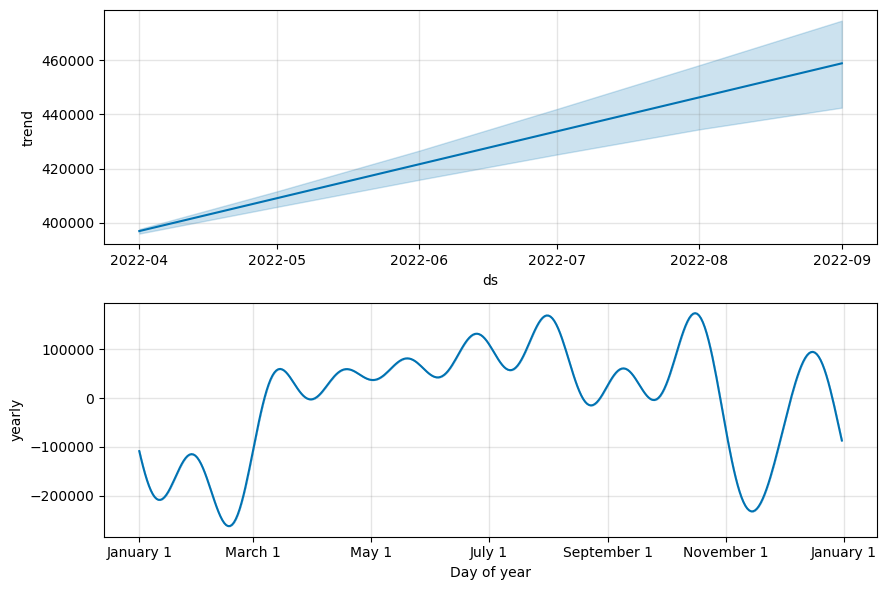

In [441]:
# To plot the forecast componenets
plt_monthly = model.plot_components(forecast_monthly)

## Observations From Component Plots
The above plots show:
- There is a increase in revenue over time that the forecast is made for, however the error lines are significantly larger than for the other forecasts. Again this is most likely due to the lack of training data and therefore larger error range when forecasting. 
- The yearlys easonality is showing a strange pattern, that is not quite true based on the EDA and daily and weekly forecasts. It shows a relatively constant but fluctuating peak from April to August and another large peak in October. This is most likely due to the months it shows peaks for having school holidays fall in, versus the negative revenue due to the winter months. This suggests that the model has not quite captured the seasonality correctly, but incldued it in the trend. 
---

# Summary
To conclude, a total of 13 models were run across the daily, weekly and monthly revenue forecasts. The best models have their accuracy scores summarised in the below table: 

|Forecast| Model | MAPE | Comments |
|:--| :- | :- | :--|
|Daily|5| 9.5 %| Added TAVG |
|Weekly|4| 8.5 %| Holidays and tuned hyperparameters| 
|Monthly|2| 28.0 %| Hyperparameters tuned, no holidays|

The weekly forecast was almost as accurate as the current best SARIMAX model. This model appeared to account for the school holidays well. To further improve this model in the future so that is is perhaps better than the SARIMAX model, more data should be included. 

The monthly forecast produced particularly poor models, even worse than the baseline moving average models. This is most likely due to the severe lack of data required for the Facebook Propehet model to work effectively and capture the true trend. 


None of these models are more accurate than the previous models though, which are summarised below. 

|MAPE Score| Moving Average | Linear Regression | SARIMAX| Facebook Prophet|
|:--| :- | :- | :--|:--|
|Daily|20.7 %| 7.7 %|  5.9 % | 9.5 %|
|Weekly |24.8 %| 9.9 %| 8.2 %| 8.5 % | 
|Monthly|17.0 %|13.3 %| 7.1 %| 28.0 %|


# Further Improvements
- Larger data size collected, in particular for the monthly forecast
- Further hyperparameter tuning with different initial and periods set 
- Additional regressors explored, such as a lagged moving average as in the Linear Regression model 
- Use daily or weekly models to forecast the 6 months ahead and sum the predicted revenue to be monthly

# Next Steps
- A comparison of all the models in a final report summary outlining all the steps taken and insights gained through this project

>[Return to Contents](#Contents)